In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


# 1. Load data

In [3]:
# alldata = np.load('processed_endomondoHR_proper_interpolate.npy', allow_pickle=True)

In [4]:
alldata = []
for i in range(10 + 1):
    alldata.extend(np.load('subDataset/processedData{}.npy'.format(i), allow_pickle=True))

In [5]:
len(alldata)

102992

# 2. data analysis

In [6]:
countType = defaultdict(int)

In [7]:
for sample in alldata:
    countType[sample['sport']] += 1

In [8]:
countType = sorted(countType.items(), key = lambda x: -x[1])

In [9]:
name = []
counts = []
for k,v in countType:
    name.append(k)
    counts.append(v)

In [10]:
countType

[('bike', 48493),
 ('run', 39201),
 ('mountain bike', 7711),
 ('bike (transport)', 3234),
 ('indoor cycling', 1320),
 ('cross-country skiing', 630),
 ('walk', 618),
 ('orienteering', 553),
 ('core stability training', 258),
 ('hiking', 193),
 ('fitness walking', 186),
 ('roller skiing', 158),
 ('skate', 124),
 ('kayaking', 60),
 ('circuit training', 53),
 ('rowing', 46),
 ('weight training', 31),
 ('downhill skiing', 24),
 ('soccer', 21),
 ('snowshoeing', 15),
 ('golf', 11),
 ('horseback riding', 7),
 ('tennis', 5),
 ('treadmill running', 5),
 ('badminton', 5),
 ('climbing', 5),
 ('basketball', 4),
 ('swimming', 4),
 ('table tennis', 3),
 ('rugby', 3),
 ('snowboarding', 2),
 ('elliptical', 2),
 ('gymnastics', 1),
 ('aerobics', 1),
 ('sailing', 1),
 ('kite surfing', 1),
 ('squash', 1),
 ('stair climing', 1),
 ('martial arts', 1)]

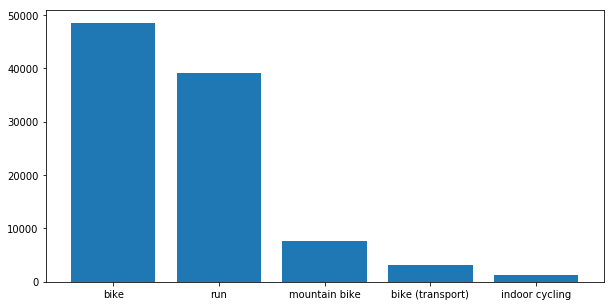

In [11]:
numOfSport = 5
plt.figure(figsize = (10,5))
plt.bar(name[:numOfSport], counts[:numOfSport])
# plt.title("The MSE  vs different lambda", fontsize=18)
# plt.xlabel("lambda", fontsize=18)
# plt.ylabel("MSE", fontsize=18)
# plt.legend()
# plt.tick_params(labelsize=15)
plt.show()
# bestIndex = np.argmin(MSEs_total)
# print('we can see the smallest MSE is {:.4f} with lambda {:.5f}.'\
#       .format(MSEs_total[bestIndex], lambs_total[bestIndex]))

In [12]:
# np.save('processedData.npy', data, allow_pickle=True)

In [13]:
# for sportType in name:
#     print(sportType)
#     with open('subDataset/'+sportType+'DataSet.json','w') as outfile:
#         for sample in data:
#             if sample['sport'] == sportType:   
# #                 print(type(sample))
#                 json.dump(sample,outfile,ensure_ascii=False)
#                 outfile.write('\n')


# 3. class and feature selection

In [14]:
UsedClass = name[:5]
# weight = sum(counts[:5])/ torch.tensor(counts[:5]).float()

In [15]:
UsedClass

['bike', 'run', 'mountain bike', 'bike (transport)', 'indoor cycling']

In [48]:
labelIndex = dict()
for i, sport in enumerate(UsedClass):
    labelIndex[sport] = i
# def feature(sample, numOfFre = 5):
#     featureList = []
#     featureList.append(labelIndex[sample['sport']])
#     featureList.extend([1,0] if sample['gender'] == 'male' else [0,1])
#     featureList.extend(sample['heart_rate'][::numOfFre])
#     featureList.extend(sample['longitude'][::numOfFre])
#     featureList.extend(sample['latitude'][::numOfFre])
#     featureList.extend(sample['altitude'][::numOfFre])
#     featureList.extend(sample['distance'][::numOfFre])
#     featureList.extend(sample['derived_speed'][::numOfFre])    
#     return featureList


def feature(sample, numOfFre = 7):
    featureList = []
    featureList.append(labelIndex[sample['sport']])
    featureList.extend([1,0] if sample['gender'] == 'male' else [0,1])
    featureList.extend(sample['heart_rate'][:numOfFre])
    featureList.extend(sample['longitude'][:numOfFre])
    featureList.extend(sample['latitude'][:numOfFre])
    featureList.extend(sample['altitude'][:numOfFre])
    featureList.extend(sample['distance'][:numOfFre])
    featureList.extend(sample['derived_speed'][:numOfFre])    
    return featureList

In [49]:
data = np.array([feature(sample) for sample in alldata if sample['sport'] in UsedClass], dtype= 'float32')

In [50]:
train_data, val_test_data = train_test_split(data, test_size=1/5)
val_data, test_data = train_test_split(val_test_data, test_size=1/2)

In [51]:
XTrain = train_data[:,1:]
YTrain = train_data[:,0]

XTest = torch.from_numpy(test_data[:,1:]).cuda()
YTest = torch.from_numpy(test_data[:,0])

XVal = val_data[:,1:]
YVal = val_data[:,0]

In [52]:
class sportDataset(td.Dataset):
    def __init__(self, X, Y): # initialize
        super(sportDataset, self).__init__() # initialize the superclass
        self.X = X.astype('float32')
        self.Y = Y.astype('int64')
    def __len__(self):
        return len(self.X) # return the size of dataset
    def __getitem__(self, idx):
        x = self.X[idx] # do transformation
        d = self.Y[idx] # get label
        return x, d # return data and label
    def number_of_classes(self):
        return self.Y.max() + 1 # return the number of classes

In [53]:
train_set = sportDataset(XTrain, YTrain)
train_loader = td.DataLoader(train_set, batch_size = 100, shuffle = True, pin_memory = True)
len(train_loader)

800

In [54]:
val_set = sportDataset(XVal, YVal)
val_loader = td.DataLoader(val_set, batch_size = 100, shuffle = False, pin_memory = True)
len(val_loader)

100

In [55]:
# test_set = sportDataset(XTest, YTest)
# test_loader = td.DataLoader(test_set, batch_size = 100, shuffle = False, pin_memory = True)
# len(test_loader)

# 4. train model

In [56]:
# class NNModel(nn.Module):

#     def __init__(self, input_size, output_size, layers, p=0.5, device = 'cuda'):
#         super().__init__()
#         self.device = device
#         self.batch_norm_num = nn.BatchNorm1d(input_size)

#         all_layers = []

#         for i in layers:
#             all_layers.append(nn.Linear(input_size, i))
#             all_layers.append(nn.ReLU(inplace=True))
#             all_layers.append(nn.BatchNorm1d(i))
#             all_layers.append(nn.Dropout(p))
#             input_size = i

#         all_layers.append(nn.Linear(layers[-1], output_size))

#         self.layers = nn.Sequential(*all_layers)
        

#     def forward(self, x):
#         x = self.layers(x)
#         return x
class NNModel(nn.Module):

    def __init__(self, input_size, output_size, layers, p=0.5, device = 'cuda'):
        super().__init__()
        self.device = device

        all_layers = []
        input_size = input_size-2
        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        self.classifier_layers = nn.Linear(layers[-1]+2, output_size)

        self.layers = nn.Sequential(*all_layers)
        

    def forward(self, x):
        y = self.layers(x[:,2:])
        y = self.classifier_layers(torch.cat((y, x[:,0:2]),1))
        return y

In [57]:
def backprop_deep(net, T, gamma=.001, rho=.9, weight = None, output_dir = None): 
    if weight is not None:
        weight = weight.cuda()    
    criterion = nn.CrossEntropyLoss(weight)
    optimizer = torch.optim.SGD(net.parameters(), lr=gamma, momentum=rho)
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    minVal_loss = float('inf')
    minValCount = 0
    
    for epoch in range(T): 
        running_loss = 0.0 
        train_loss = 0.0
        train_correct = 0.0
        net.train()
        count = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(net.device), labels.to(net.device)
            # Initialize the gradients to zero
            optimizer.zero_grad()
            # Forward propagation
            outputs = net(inputs)
            # Error evaluation
            loss = criterion(outputs, labels)
            # Back propagation
            loss.backward()
            # Parameter update
            optimizer.step()
            with torch.no_grad():
                running_loss += loss.item() 
                train_loss += loss.item()
                _, y_pred = outputs.max(-1)
                correct = sum(y_pred == labels).item()
                train_correct += correct
            count += len(labels)
            if (count // len(labels)) % 1000 == 0:
                print('Iteration %d, count %d, running loss: %.3f' %
                      (epoch + 1, count, running_loss))
                running_loss = 0.0
        train_losses.append(train_loss/8)
        train_accs.append(train_correct/count*100)
        print('Iteration %d, train loss: %.3f train acc : %.3f' % \
                  (epoch + 1, train_loss/8, train_correct/count*100))               
                
        ## validation   
        val_loss = 0
        val_correct = 0.0
        val_count = 0.0
        net.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(net.device), labels.to(net.device)
                # Initialize the gradients to zero
                optimizer.zero_grad()
                # Forward propagation
                outputs = net(inputs)
                # Error evaluation
                loss = criterion(outputs, labels)
                val_loss += loss.item() 
                _, y_pred = outputs.max(-1)
                correct = sum(y_pred == labels).item()
                val_correct += correct
                val_count += len(labels)
                
        print('Iteration %d, validation loss: %.3f validation acc: %.3f' % \
                  (epoch + 1, val_loss, val_correct/val_count*100))
        minValCount += 1
        if val_loss < minVal_loss:
            minVal_loss = val_loss
            minValCount = 0
            
            if output_dir is None:
                if weight is not None:
                    output_dir = 'checkpoint/NN/weight/experiment_nn{}'.format(time.time())
                else:
                    output_dir = 'checkpoint/NN/unweighted/experiment_nn{}'.format(time.time())
            os.makedirs(output_dir, exist_ok=True)
            checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
            config_path = os.path.join(output_dir, "config.txt")
            state_dict = {'Net': net.state_dict(), 'Optimizer': optimizer.state_dict()}
            torch.save(state_dict, checkpoint_path)
            with open(config_path, 'w') as f:
                print(net, file=f)
            
            
        val_losses.append(val_loss)
        val_accs.append(val_correct/val_count*100)
        if minValCount > 20:
            break
    checkpoint = torch.load(checkpoint_path, map_location=net.device)
    net.load_state_dict(checkpoint['Net'])
    print("Finish training for {} epochs".format(T))
    return train_losses, val_losses, train_accs, val_accs

In [58]:
nnmodel = NNModel(len(XTrain[0]), len(UsedClass), [400, 300, 200, 20]).to(device)
# nnmodel

In [59]:
epochs = 500
train_losses, val_losses, train_accs, val_accs = backprop_deep(nnmodel, T=epochs )

Iteration 1, train loss: 99.716 train acc : 67.085
Iteration 1, validation loss: 79.771 validation acc: 76.251
Iteration 2, train loss: 77.602 train acc : 75.227
Iteration 2, validation loss: 68.174 validation acc: 78.051
Iteration 3, train loss: 74.011 train acc : 76.407
Iteration 3, validation loss: 63.422 validation acc: 79.592
Iteration 4, train loss: 71.768 train acc : 77.277
Iteration 4, validation loss: 61.031 validation acc: 80.602
Iteration 5, train loss: 69.986 train acc : 77.947
Iteration 5, validation loss: 64.406 validation acc: 79.642
Iteration 6, train loss: 68.728 train acc : 78.370
Iteration 6, validation loss: 59.681 validation acc: 81.172
Iteration 7, train loss: 67.423 train acc : 78.736
Iteration 7, validation loss: 59.177 validation acc: 81.533
Iteration 8, train loss: 66.680 train acc : 79.094
Iteration 8, validation loss: 60.058 validation acc: 81.012
Iteration 9, train loss: 66.596 train acc : 79.128
Iteration 9, validation loss: 65.274 validation acc: 79.342
I

Iteration 74, train loss: 56.128 train acc : 81.541
Iteration 74, validation loss: 50.767 validation acc: 82.923
Iteration 75, train loss: 56.105 train acc : 81.704
Iteration 75, validation loss: 52.787 validation acc: 82.383
Iteration 76, train loss: 56.076 train acc : 81.581
Iteration 76, validation loss: 49.881 validation acc: 82.903
Iteration 77, train loss: 56.217 train acc : 81.410
Iteration 77, validation loss: 55.620 validation acc: 82.013
Iteration 78, train loss: 55.967 train acc : 81.619
Iteration 78, validation loss: 57.715 validation acc: 81.283
Iteration 79, train loss: 55.968 train acc : 81.627
Iteration 79, validation loss: 57.303 validation acc: 81.413
Iteration 80, train loss: 56.000 train acc : 81.615
Iteration 80, validation loss: 49.465 validation acc: 82.893
Iteration 81, train loss: 55.989 train acc : 81.565
Iteration 81, validation loss: 58.605 validation acc: 81.443
Iteration 82, train loss: 56.077 train acc : 81.656
Iteration 82, validation loss: 52.557 valida

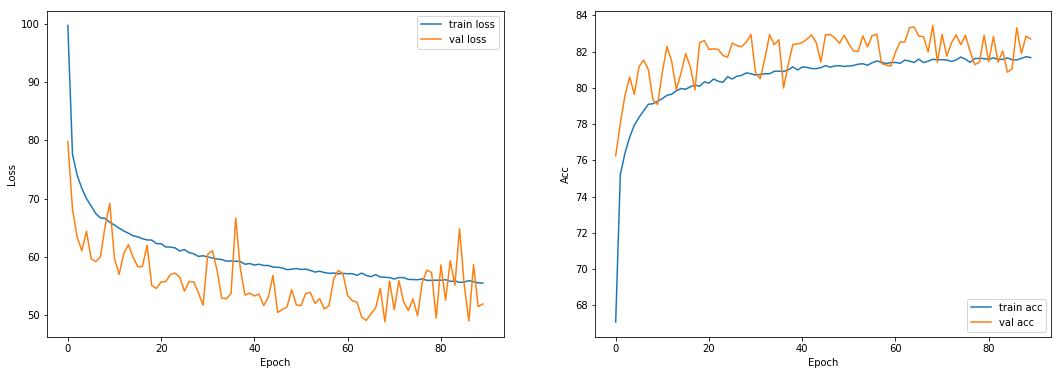

In [60]:
final_epochs = len(train_losses)
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))

axes[0].plot(range(final_epochs), train_losses, label = 'train loss')
axes[0].plot(range(final_epochs), val_losses, label = 'val loss')
axes[0].set_xlabel('Epoch') 
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(range(final_epochs), train_accs, label = 'train acc')
axes[1].plot(range(final_epochs), val_accs, label = 'val acc')
axes[1].set_xlabel('Epoch') 
axes[1].set_ylabel('Acc')
axes[1].legend()

# 5. test model

In [61]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def testModel(xtest, ytest, net): 
    net.eval()
    with torch.no_grad():
        outputs = net(xtest).cpu()
    y_val = np.argmax(outputs, axis=1)   
    print(confusion_matrix(ytest,y_val))
    print(classification_report(ytest,y_val))
    print(accuracy_score(ytest, y_val))
    return confusion_matrix(ytest,y_val)
# def testModel(xtest, ytest, net): 
#     net.eval()
#     with torch.no_grad():
#         outputs = net(xtest)
#     _, y_val = outputs.max(-1)
#     correct = sum(y_val == ytest).item()
#     acc =  correct / len(y_val) * 100
#     return acc, correct
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [62]:
cnf_matrix = testModel(XTest, YTest, nnmodel)

[[4617  217    1    0    0]
 [ 267 3663    0    0    0]
 [ 686   86    0    1    0]
 [ 300   26    0    0    0]
 [ 110   22    0    0    0]]
              precision    recall  f1-score   support

         0.0       0.77      0.95      0.85      4835
         1.0       0.91      0.93      0.92      3930
         2.0       0.00      0.00      0.00       773
         3.0       0.00      0.00      0.00       326
         4.0       0.00      0.00      0.00       132

   micro avg       0.83      0.83      0.83      9996
   macro avg       0.34      0.38      0.36      9996
weighted avg       0.73      0.83      0.78      9996

0.8283313325330132


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Normalized confusion matrix
[[9.55e-01 4.49e-02 2.07e-04 0.00e+00 0.00e+00]
 [6.79e-02 9.32e-01 0.00e+00 0.00e+00 0.00e+00]
 [8.87e-01 1.11e-01 0.00e+00 1.29e-03 0.00e+00]
 [9.20e-01 7.98e-02 0.00e+00 0.00e+00 0.00e+00]
 [8.33e-01 1.67e-01 0.00e+00 0.00e+00 0.00e+00]]


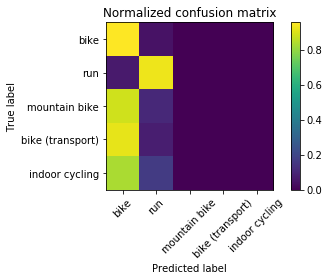

In [63]:
# Compute confusion matrix

np.set_printoptions(precision=2)
class_names = UsedClass
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()